## Meta data

In [81]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
import scipy.ndimage as nd
import scipy.optimize as opt
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
from matplotlib import rcParams
rcParams['pcolor.shading']='auto'

expname='qwa116'  #      <============ Change run name here !

pathdir='/home6/datawork/abarboni/CROCO/TEMP_1km/SAVE_HIS-AVG/'
path_ameda='/home6/datawork/abarboni/CROCO/RESULT/'+expname.upper()+'/'

filename=pathdir+expname+'_his.nc'
avg_name=pathdir+expname+'_avg.nc'
gridname=pathdir+'grd_lat385_1km.nc' #1km_x100.nc'

timestep=2 ## time in day between time step of netcdf _avg file
rg=1 # side padding to reduce data size 
depth_m=300  # index of deepest level extracted
depth_surf=15  ## depth of near surface value chosen, in meters
Xmax=100 # (half) window size in km
f_coriolis=1e-4
mldthres=0.1

Navg=2   ### padding between _his and _avg files : timestep(avg) = Navg*timestep(his)
Nt=1 # timestep selection (keep it to 1)

str_title='Run '+expname.upper()+' - AE 1km ERA5 1-hour '
str_title

'Run QWA116 - AE 1km ERA5 1-hour '

## Loading data

In [2]:
### Grid   ### MAKE SURE IT IS THE GOOD ONE !
f=nc4.Dataset(gridname)   
x_rho=f['x_rho'][rg:-rg,rg:-rg]/1000 ; y_rho=f['y_rho'][rg:-rg,rg:-rg]/1000
xi_rho=x_rho[0,:]
xmid=int(f.dimensions['xi_rho'].size/2)
f.close()
x_psi=(x_rho[1:,1:]+x_rho[1:,:-1]+x_rho[:-1,1:]+x_rho[:-1,:-1])/4
y_psi=(y_rho[1:,1:]+y_rho[1:,:-1]+y_rho[:-1,1:]+y_rho[:-1,:-1])/4
dx=np.diff(x_rho, axis=1)[0,0]*1000 ; dy=np.diff(y_rho, axis=0)[0,0]*1000 # in meters
x_div=x_rho[1:-1,1:-1] ; y_div=y_rho[1:-1,1:-1]
xi_psi=x_psi[0]

In [3]:
### AVG Data
f=nc4.Dataset(avg_name) #filename)
srho=f['s_rho'][:]
H0=f['h'][0,0] ; hc=f['hc'][:]
### Streching coeff
Csr=f['Cs_r'][:] ; sw=f['s_w'][:] ; Csw=f['Cs_w'][:] 
#######z0=hc*srho+(H0-hc)*Csr ## OLD S COORD
z0=H0*(hc*srho+H0*Csr)/(hc+H0) ## NEW S COORD
z_w= H0*(hc*sw+H0*Csw)/(hc+H0) 

time=f['time'][::Nt]/24/3600 #time in days

qtot=f['shflux'][:,rg:-rg,rg:-rg]       ### FLUXES 
ustr=f['sustr'][:,rg:-rg,rg:-rg] ; vstr=f['svstr'][:,rg:-rg,rg:-rg] # in N/m^2
f.close()

In [47]:
ids=np.argmin(np.abs(z0+depth_surf))
idmax=np.argmin(np.abs(z0+depth_m)) 
zvert=z0[idmax:] ; z_dzt=z_w[idmax:]
Nvert=len(zvert) ; Nx=len(xi_rho) ; Ny=len(xi_rho) ; Ns=len(time) #numb timesteps

In [5]:
### HIS file  = BIG DATA
f=nc4.Dataset(filename) 
U=f['u'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]   
V=f['v'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]

SST=f['temp'][int(Navg/2)::Navg,-1,rg:-rg,rg:-rg] 
time_h=f['time'][int(Navg/2)::Navg]/24/3600#time in days
temp_h=f['temp'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
AKv=f['AKt'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
# W_h=f['w'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]   ## uncomment vertical speed if needed
#Eps=f['gls'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]  ### Warning : dissipation rate epsilon is under 'gls' variable depending on GLS_MIXING choices
f.close()
Nh=len(time_h)

### Checking Heat fluxes

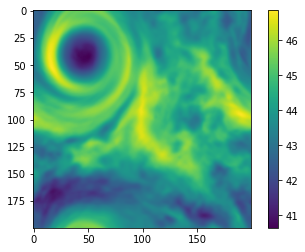

In [6]:
plt.imshow(qtot[-10]) ; plt.colorbar()
Qmean=np.mean(qtot, axis=(1,2))
Umean=np.mean(ustr,axis=(1,2)) ; Vmean=np.mean(vstr,axis=(1,2)) ; Wmean=np.sqrt(Umean**2+Vmean**2)
Wspeed=np.sqrt(Wmean/0.0016/1.2)

In [7]:
### Vorticity
Vort=(np.diff(V,axis=2)/dx-np.diff(U,axis=1)/dy)/f_coriolis


## Computing MLD

In [41]:
fmld = interp.interp1d(np.arange(len(zvert)), zvert)  ### interpolation function, useful for later

In [8]:
MLDind_h=np.zeros((Nh, Nx,Nx))   #### HIS version
for t in tqdm(range(Nh)):
    DT=(np.abs(temp_h[t,:]-temp_h[t,-1])<mldthres)
    MLDind_h[t]=np.argmin(~DT,axis=0)

100%|██████████| 389/389 [00:03<00:00, 106.25it/s]


<ipython-input-11-c6642e5e8a67>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_yticklabels(labels)


[Text(1, 30.0, '-108'),
 Text(1, 35.0, '-87'),
 Text(1, 40.0, '-68'),
 Text(1, 45.0, '-49'),
 Text(1, 50.0, '-30'),
 Text(1, 55.0, '-12')]

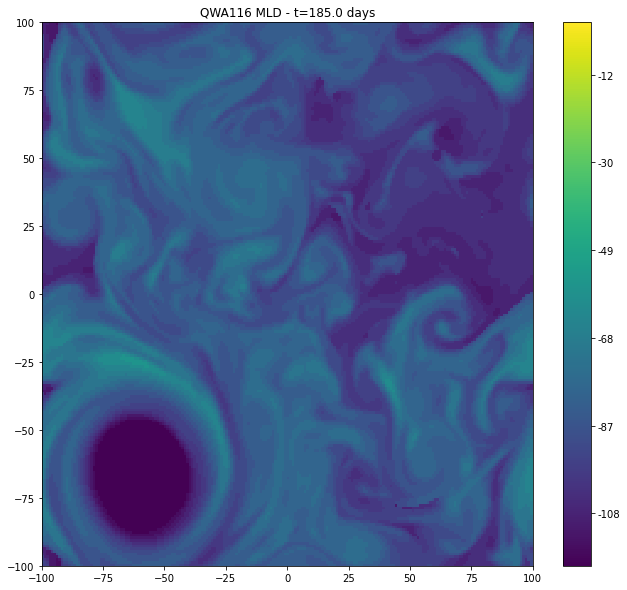

In [11]:
t=92 ### Check MLD
MLDmax=120
plt.figure(0,figsize=(11,10))
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert)-1)
#ticks = [ x for x,i in enumerate(zvert.astype(int))] ; labels=[str(x) for x in zvert.astype(int)]
CB=plt.colorbar() #; CB.ax.set_yticks(ticks) ; 
#CB.ax.set_yticklabels(labels[::7])
plt.title(str_title[4:10]+ ' MLD - t='+'%3.1f'%time_h[t]+' days')
ticks=CB.get_ticks()
labels=['%3.0f'%(fmld(x)) for x in ticks]
CB.ax.set_yticklabels(labels)

## Loading AMEDA result (with HDF5 refs)

In [12]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

## Grid
grid_dict = sio.loadmat(path_ameda+'gridvel_deg'+str(deg)+'_resol'+str(resol)+'.mat')
x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Tracks
D = h5py.File(path_ameda+'eddy_tracks.mat','r')  ## Or tracks2.mat ??
tracks=D['tracks']
Ned=tracks['step'].shape[0]
## Syntax : 
#D[D[tracks['shapes1'][Eddy_nb,0]][0][Timestep]][Streamline, X/Y]

print('Number of timesteps :'+str(int(params_dict['stepF'])) ) ## Checking time and shape
print('Number of eddies :'+str(Ned))

Number of timesteps :388
Number of eddies :229


In [13]:
StepEddy=np.zeros((Ned, len(time)))  ## Presence matrix
#StepEddy=np.zeros((Ned, len(time_h)+1))  ## Presence matrix
Polarity=np.zeros(Ned)
for i in range(Ned):
    StepEddy[i,D[tracks['step'][i,0]][0].astype(int)-1]=1  
    ### "-1" is important because steps are counted in Matlab, in Python first index starts at 0
    Polarity[i]=np.mean(D[tracks['type'][i,0]][0].astype(int))
Color=np.zeros(Ned).astype(str)
Color[Polarity==-1]='b' ; Color[Polarity==1]='r'

Text(0.5, 1.0, 'Eddy occurence matrix')

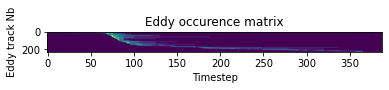

In [14]:
plt.imshow(StepEddy, aspect=1/10) ; plt.xlabel('Timestep') ; plt.ylabel('Eddy track Nb')
plt.title('Eddy occurence matrix')
## np.where(StepEddy[0,:]) #: to have index of first appearance

## Selecting anticyclone main track (touchy)

This step is touchy as the main anticyclone tracked can be considered simply as the one having the longest lifetime.
However AMEDA does not understand periodic borders (in the considered version). Then if the anticyclone crosses the domain borders, you have to manually change track by indicating with the variable `DayEddy` the timestep range for each partial track.

Check later with SST plots that the considered main track is always in the domain (by showing also track numbers)

### Automatic version (in case no border crossing)

In [15]:
MainEddy=np.where((np.sum(StepEddy, axis=1)>200) & (Polarity==-1))[0]
print( 'Eddy index living more than x timesteps :')
[ x for x in MainEddy.astype(str)]  ### there should be only one track living more than 200 timesteps

Eddy index living more than x timesteps :


['0']

Text(0, 0.5, 'Days')

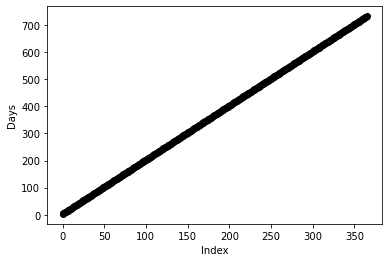

In [16]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for h in MainEddy:  ## MainEddy should contain only the eddy to be tracked !!
    Rmax+=list(D[tracks['rmax1'][h,0]][0])
    Vmax+=list(D[tracks['velmax1'][h,0]][0])
    timeeddy+=list(D[tracks['step'][h,0]][0]*timestep+time[0])
    X1+=list(D[tracks['x1'][h,0]][0]) ; Y1+=list(D[tracks['y1'][h,0]][0])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

### Manual tracking (in case border crossing)

In [37]:
#### MANUAL SELECTION

#MainEddy=np.array([0,44]) ### QWA115
#DayEddy=np.array([[0,420],[422,720]])

MainEddy=np.array([0,158]) ### QWA204    <=== indicate the indivual tracks
DayEddy=np.array([[0,220],[221,360]])*timestep#  <== indicate the valid step range for each track   

In [ ]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for ide,h in enumerate(MainEddy):
    steps=D[tracks['step'][h,0]][0]*timestep+time[0]  ## Adding time_h[0] in case of restart\
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]

    Rmax+=list(D[tracks['rmax1'][h,0]][0][ided])
    Vmax+=list(D[tracks['velmax1'][h,0]][0][ided])
    timeeddy+=list(D[tracks['step'][h,0]][0][ided]*timestep+time[0])
    X1+=list(D[tracks['x1'][h,0]][0][ided]) ; Y1+=list(D[tracks['y1'][h,0]][0][ided])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

##  SST Scaling

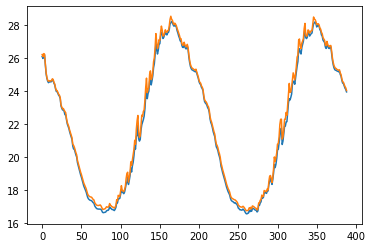

In [17]:
SSTmax_h=np.max(SST,axis=(1,2))   ### HIS version
SSTmin_h=np.min(SST,axis=(1,2))
SSTmean_h=np.mean(SST,axis=(1,2)) #nd.gaussian_filter1d(np.mean(temp_h[:,-1],axis=(1,2)),sigma=2)
plt.plot(SSTmin_h) ; plt.plot(SSTmean_h)

In [18]:
cust=cm.Spectral_r ; Ncycl=0
my_cmap = cust(np.arange(cust.N))
my_cmap[:,-1] = 1-0.9*(np.sin(np.linspace(0, Ncycl*np.pi, cust.N))**10) #np.linspace(0, 1, cust.N)
my_cmap = col.ListedColormap(my_cmap)

## SST & MLD maps with AMEDA

100%|██████████| 33/33 [00:00<00:00, 259.74it/s]
<ipython-input-19-945ba8d92c8b>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_yticklabels(labels) ; CB.ax.tick_params(labelsize=25)


Text(0.5, 0.95, 'Run QWA116 - AE 1km ERA5 1-hour  - t= 185 days')

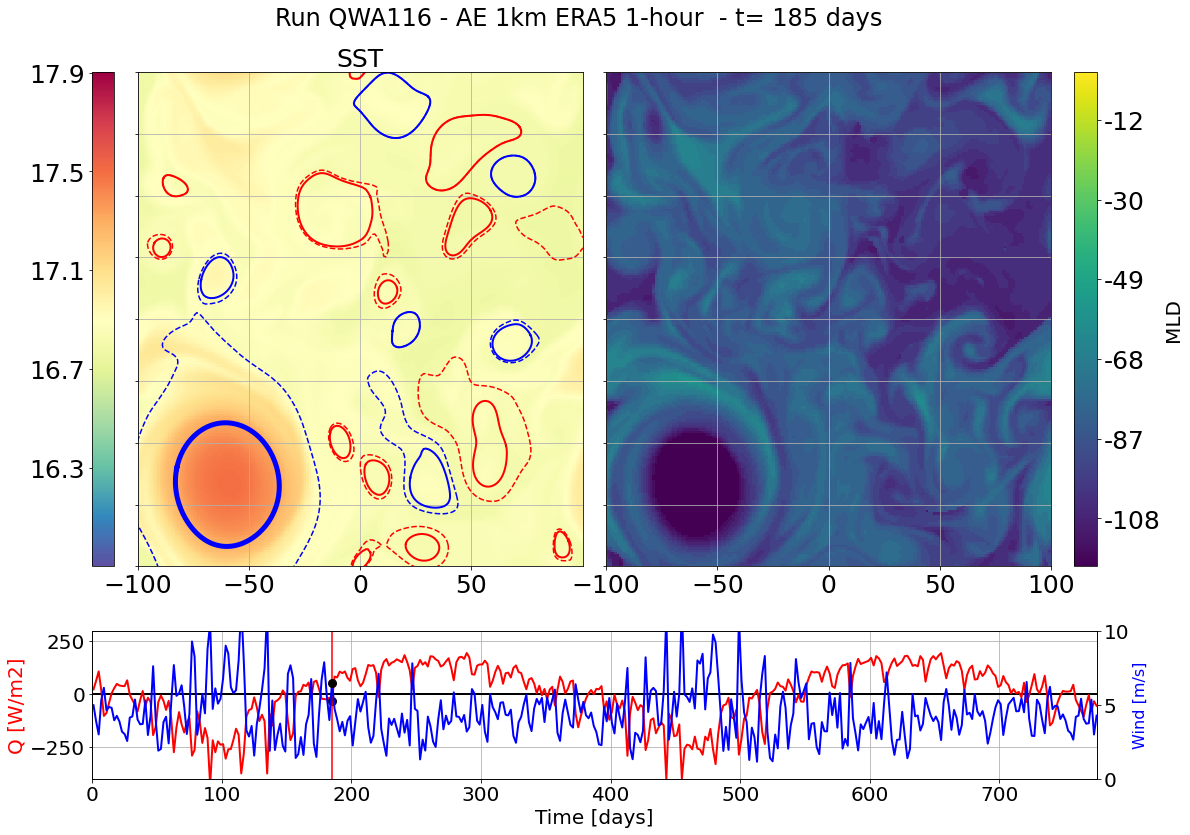

In [19]:
### Just 1 timstep
t=92  # chosen timestep
plot_number=False ;     ### To plot track number and be sure which one is plotted
dTmax=1                ### colorbar range
SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2-(SSTmean_h[t]-dTmax)%1,0.4)

plt.figure(0, figsize=(18,13))
gs = GridSpec(2, 4, width_ratios=[1/20,1,1,1/20], height_ratios=[10,3], wspace=0.1, hspace=0.2)

### SST
plt.subplot(gs[0,1])
plt.pcolormesh(xi_rho,xi_rho,SST[t,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=cm.Spectral_r)

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    if plot_number:
        plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=25)  
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() #; plt.ylabel('Distance [km]', size=18)
plt.xticks(np.arange(-100,100,50))
plt.tick_params(labelleft=False, labelsize=25)
CB1=plt.colorbar(cax=plt.subplot(gs[0,0]))#, orientation='horizontal')
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=25)

plt.subplot(gs[0,2])  ### MLD
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert)-1)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
plt.xticks(np.arange(-100,110,50))
plt.tick_params(labelleft=False, labelsize=25)
CB=plt.colorbar(cax=plt.subplot(gs[0,-1])) 
ticks=CB.get_ticks()
labels=['%3.0f'%(fmld(x)) for x in ticks]
CB.ax.set_yticklabels(labels) ; CB.ax.tick_params(labelsize=25)
CB.ax.set_ylabel('MLD', fontsize=20)

ax1=plt.subplot(gs[1,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
plt.tick_params(labelsize=20)
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=20, color='r')
plt.ylim([-400,300])
plt.xlabel('Time [days]', size=20)

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.tick_params(labelsize=20)
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=24, y=0.95)


## Computing eddy mask

AMEDA contours are used to crop outside- and inside-eddy areas at each timesteps through masks
=> Masks are defined at time steps _avg

In [20]:
xlist=np.reshape(x_rho,len(x_rho)**2) ; ylist=np.reshape(y_rho,len(x_rho)**2)
#xpsilist=np.reshape(x_psi,len(x_psi)**2) ; ypsilist=np.reshape(y_psi,len(x_psi)**2)
pts=np.array([xlist,ylist]).T #; ptspsi=np.array([xpsilist,ypsilist]).T

In [21]:
MaskEnd=np.zeros((Ns, Nx,Nx))      ### mask in time_avg !
for t in tqdm(range(len(time))):
    ListPs=np.where(StepEddy[:,t])[0]
    ### Mask removing all eddies
    for i in range(len(ListPs)):
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]## Rmax or Rend : 'shapes1' or 'shapes3'
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) ; MaskEnd[t]+=Inside  

100%|██████████| 388/388 [01:07<00:00,  5.78it/s]


In [23]:
MaskMain=np.zeros((Ns, Nx, Nx)) 
if not 'DayEddy' in locals(): #### in the case no border crossing, DayEddy is not defined
    DayEddy=np.array([[0,time_h[-1]]])    

for ide,h in enumerate(tqdm(MainEddy)):  # iteration on track number
    steps=D[tracks['step'][h,0]][0]*timestep+time_h[0]
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]
    for idbis in ided :
        Contour=D[D[tracks['shapes1'][h,0]][0][idbis]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho))
        MaskMain[int((steps[idbis]-time_h[0])/timestep)-1]+=Inside  

100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


In [61]:
## Mask to compute deltaT from Evangelos method
MaskRmaxIn=np.zeros((Ns,Nx,Nx)) ;  MaskRmaxOut=np.zeros((len(time), len(x_rho),len(x_rho)))
#Rmin=10 # for eddy core, in km
for x in tqdm(range(len(X1))):
    Dist=np.sqrt((pts[:,0]-X1[x])**2+(pts[:,1]-Y1[x])**2)
    #MaskRmaxIn[int((timeeddy[x]-time_h[0])/timestep)-1]+=np.reshape(Dist<Rmin, np.shape(x_rho))
    MaskRmaxIn[int((timeeddy[x]-time_h[0])/timestep)-1]+=np.reshape(Dist<Rmax[x]*2/3, np.shape(x_rho))
    MaskRmaxOut[int((timeeddy[x]-time_h[0])/timestep)-1]+=np.reshape((Dist<Rmax[x]*2) & (Dist>Rmax[x]*2/3), np.shape(x_rho))

MaskMain=MaskMain.astype(bool) ; MaskEnd=MaskEnd.astype(bool) ; 
MaskRmaxIn=MaskRmaxIn.astype(bool) ; MaskRmaxOut=MaskRmaxOut.astype(bool)

100%|██████████| 366/366 [00:00<00:00, 1250.41it/s]


Text(0.5, 1.0, 'Masking Eddy perif')

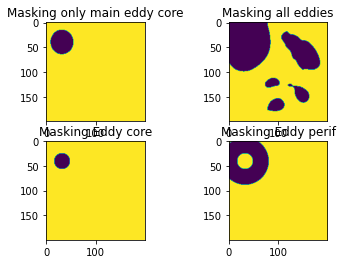

In [62]:
t=200  ## Check for 1 timestep
plt.subplot(221) ; plt.imshow(~MaskMain[t]) ; plt.title('Masking only main eddy core')
plt.subplot(222) ; plt.imshow(~MaskEnd[t]) ; plt.title('Masking all eddies')
plt.subplot(223) ; plt.imshow(~MaskRmaxIn[t]) ; plt.title('Masking Eddy core')
plt.subplot(224) ; plt.imshow(~MaskRmaxOut[t]) ; plt.title('Masking Eddy perif')

<Figure size 1440x936 with 0 Axes>

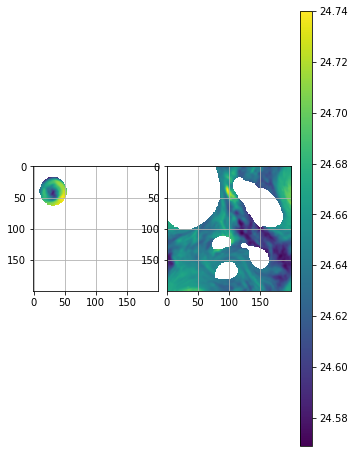

In [63]:
### Cropping example  (SST)
TempEx=np.copy(temp_h[t,-1])

plt.figure(0, figsize=(20,13))
gs = GridSpec(1, 3, width_ratios=[10,10,1], wspace=0.1, hspace=0.2)
TempEx[~MaskMain[t]]=np.nan
plt.figure(figsize=(5,8))
plt.subplot(gs[0,0])
plt.imshow(TempEx) ; plt.grid()
plt.yticks(np.arange(0,200,50))
TempEx2=np.copy(temp_h[t,-1])
TempEx2[MaskEnd[t]]=np.nan
plt.subplot(gs[0,1])
plt.imshow(TempEx2) ; plt.grid()
plt.yticks(np.arange(0,200,50))
plt.colorbar(cax=plt.subplot(gs[0,2]))

## Extracting vertical information following eddy

In [64]:
### Data from AVG
Qin=np.zeros(Ns) ; Qperif=np.zeros(Ns)
### Data from HIS
TempEddy_h=np.zeros((Ns*Nt,Nvert)) ; TempOut_h=np.zeros((Ns*Nt,Nvert)) ; TempCoreRmin_h=np.zeros((Ns*Nt,Nvert))
SSTin_h=np.zeros(Ns*Nt) ; SSTperif_h=np.zeros(Ns*Nt) ; SSTout_h = np.zeros(Ns*Nt)
MLDrmax_h=np.zeros(Ns*Nt) ; MLDout_h=np.zeros(Ns*Nt) ; MLDperif_h = np.zeros(Ns*Nt) 
WEddy_h=np.zeros((Ns*Nt,Nvert)) ; WOut_h=np.zeros((Ns*Nt,Nvert))
MixOut_h=np.zeros((Ns*Nt,Nvert)) ; MixEddy_h=np.zeros((Ns*Nt,Nvert))

### MaskMain
for t in tqdm(range(len(time))):
    if np.any(MaskMain[t]):
        for z in range(Nvert):
            for k in range(Nt):  ### Data from HIS
                TempEddy_h[t*Nt+k,z]=np.average(temp_h[t*Nt+k,z], weights=MaskMain[t])
                MixEddy_h[t*Nt+k,z]=np.average(AKv[t*Nt+k,z+1], weights=MaskMain[t])
                #WEddy_h[t*Nt+k,z]=np.average(W_h[t*Nt+k,z], weights=MaskMain[t]) 
    else:
        TempEddy_h[t]=np.nan ; MixEddy_h[t]=np.nan
        
#### MaskEnd
    if np.any(MaskEnd[t]):
        for k in range(Nt):  ### Data from HIS
            MLDout_h[t*Nt+k]=fmld(np.average(MLDind_h[t*Nt+k], weights=MaskEnd[t]))
            SSTout_h[t*Nt+k]=np.average(temp_h[t*Nt+k,-1], weights=MaskEnd[t])
            for z in range(Nvert):
                TempOut_h[t*Nt+k,z]=np.average(temp_h[t*Nt+k,z], weights=MaskEnd[t])
                MixOut_h[t*Nt+k,z]=np.average(AKv[t*Nt+k,z+1], weights=MaskEnd[t])
                #WOut_h[t*Nt+k,z]=np.average(W_h[t*Nt+k,z], weights=MaskEnd[t])
    else:
        TempOut_h[t]=np.nan ; MLDout_h[t]=np.nan ; WOut_h[t]=np.nan
        
### Mask RmaxIn-Out
    if np.any(MaskRmaxIn[t]):
        Qin[t]=np.average(qtot[t], weights=MaskRmaxIn[t]) ### Data from AVG
        Qperif[t]=np.average(qtot[t], weights=MaskRmaxOut[t])
        for k in range(Nt):  ### Data from HIS
            MLDrmax_h[t*Nt+k]=fmld(np.average(MLDind_h[t*Nt+k], weights=MaskRmaxIn[t]))
            SSTin_h[t*Nt+k]=np.average(temp_h[t*Nt+k,-1], weights=MaskRmaxIn[t])
            SSTperif_h[t*Nt+k]=np.average(temp_h[t*Nt+k,-1], weights=MaskRmaxOut[t])
            for z in range(Nvert):
                TempCoreRmin_h[t*Nt+k,z]=np.average(temp_h[t*Nt+k,z], weights=MaskRmaxIn[t])
    else:
        Qperif[t]=np.nan ; Qin[t]=np.nan
        SSTperif_h[t]=np.nan ; SSTin_h[t]=np.nan ; MLDperif_h[t]=np.nan ; MLDrmax_h[t]=np.nan ;  


100%|██████████| 388/388 [00:23<00:00, 16.32it/s]


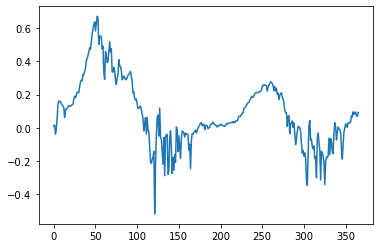

In [69]:
##### Delta SST
DeltaT_h=SSTin_h-SSTperif_h
plt.plot(DeltaT_h)   ### raw check

### Computing BVF profile

<ipython-input-78-46f47831c273>:5: RuntimeWarning: invalid value encountered in sqrt
  N_eddy_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026)
<ipython-input-78-46f47831c273>:6: RuntimeWarning: invalid value encountered in sqrt
  N_out_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempOut_h[t]-T0))/np.diff(zvert)/1026)


Text(0.5, 1.0, 'VBF profile - t= 461 days')

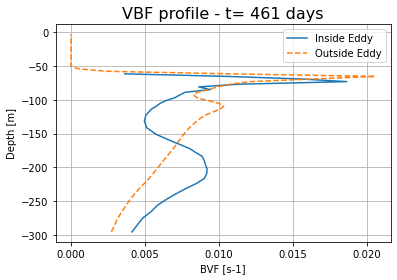

In [78]:
#def BVF(Temp,zdiff):
T0=25 ; R0=26 ; Tcoef=0.28
N_eddy_h=np.zeros((Ns,Nvert-1)) ; N_out_h=np.zeros((Ns,Nvert-1))
for t in range(Ns):
    N_eddy_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026)
    N_out_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempOut_h[t]-T0))/np.diff(zvert)/1026)
N_eddy_h[N_eddy_h<0.001]=np.nan  ### Blanking mixed areas
zs=(zvert[1:]+zvert[:-1])/2

t=230     # check for 1 timestep
plt.plot(N_eddy_h[t],zs,'-', label='Inside Eddy')
plt.plot(N_out_h[t],zs,'--', label='Outside Eddy')
plt.legend() ; plt.xlabel('BVF [s-1]') ; plt.ylabel('Depth [m]') ; plt.grid()
plt.title('VBF profile - t= '+str(int(time[t]))+' days', size=16)

Text(0.5, 1.0, 'AKv - t=105')

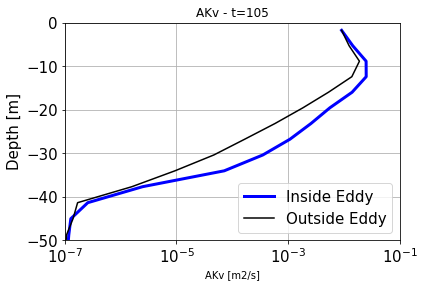

In [67]:
### Check mixing profile (AKv)
t=105 
plt.plot(MixEddy_h[t],zvert,'-b', lw=3, label='Inside Eddy')
plt.plot(MixOut_h[t],zvert,'-k', label='Outside Eddy')
#plt.plot(MixCore_h[t],z_dzt,'--', label='AE core')
plt.xscale('log') ;plt.ylim([-50,0]) ;plt.xlim([1e-7,1e-1])
plt.tick_params(labelsize=15) ; plt.grid()
plt.legend(loc=4,fontsize=15) ; plt.xlabel('AKv [m2/s]') ; plt.ylabel('Depth [m]',size=15)
plt.title('AKv - t='+str(t))

Text(0.5, 0.92, 'Run QWA116 - AE 1km ERA5 1-hour ')

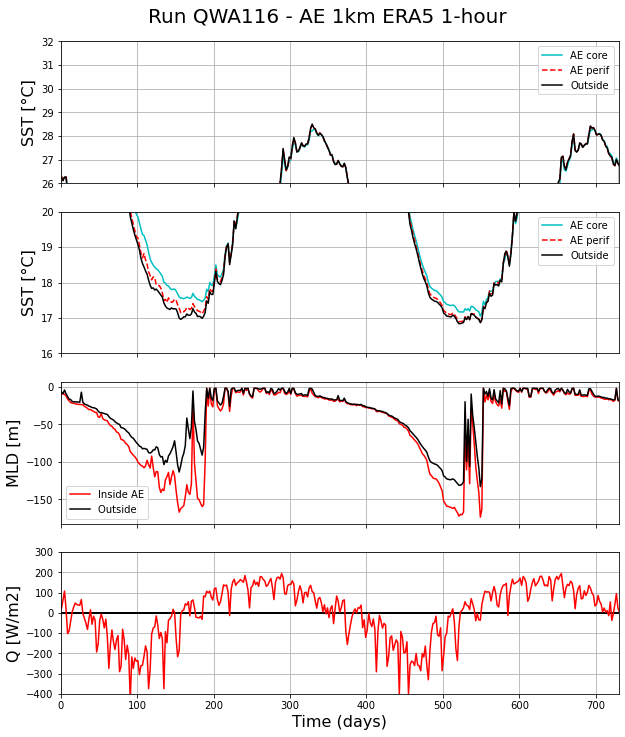

In [71]:
plt.figure(0, figsize=(10,12))

plt.subplot(411) ; plt.grid()
plt.plot(time, SSTin_h,'-c',label='AE core')
plt.plot(time, SSTperif_h,'--r',label='AE perif')
plt.plot(time, SSTout_h,'-k',label='Outside')
plt.legend() ; plt.xlim([0,730]) ; plt.ylim([26,32])
plt.tick_params(labelbottom=False)
plt.ylabel('SST [\N{DEGREE SIGN}C]', size=16)

plt.subplot(412) ; plt.grid()
plt.plot(time, SSTin_h,'-c',label='AE core')
plt.plot(time, SSTperif_h,'--r',label='AE perif')
plt.plot(time, SSTout_h,'-k',label='Outside')
plt.legend() ; plt.xlim([0,730]) ; plt.ylim([16,20])
plt.tick_params(labelbottom=False)
plt.ylabel('SST [\N{DEGREE SIGN}C]', size=16)

plt.subplot(413) ; plt.grid()
plt.plot(time, MLDrmax_h, '-r', label='Inside AE')
plt.plot(time, MLDout_h, '-k', label='Outside ')
plt.ylabel('MLD [m]', size=16)
plt.legend() ; plt.xlim([0,730])  ; plt.tick_params(labelbottom=False)

plt.subplot(414)
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid()
plt.ylabel('Q [W/m2]',size=16)
plt.xlim([0,730]) ; plt.ylim([-400,300])
plt.xlabel('Time (days)', size=16)

plt.suptitle(str_title, y=0.92,size=20)

Text(0.5, 0.92, 'Run QWA116 - AE 1km ERA5 1-hour  - HIS data')

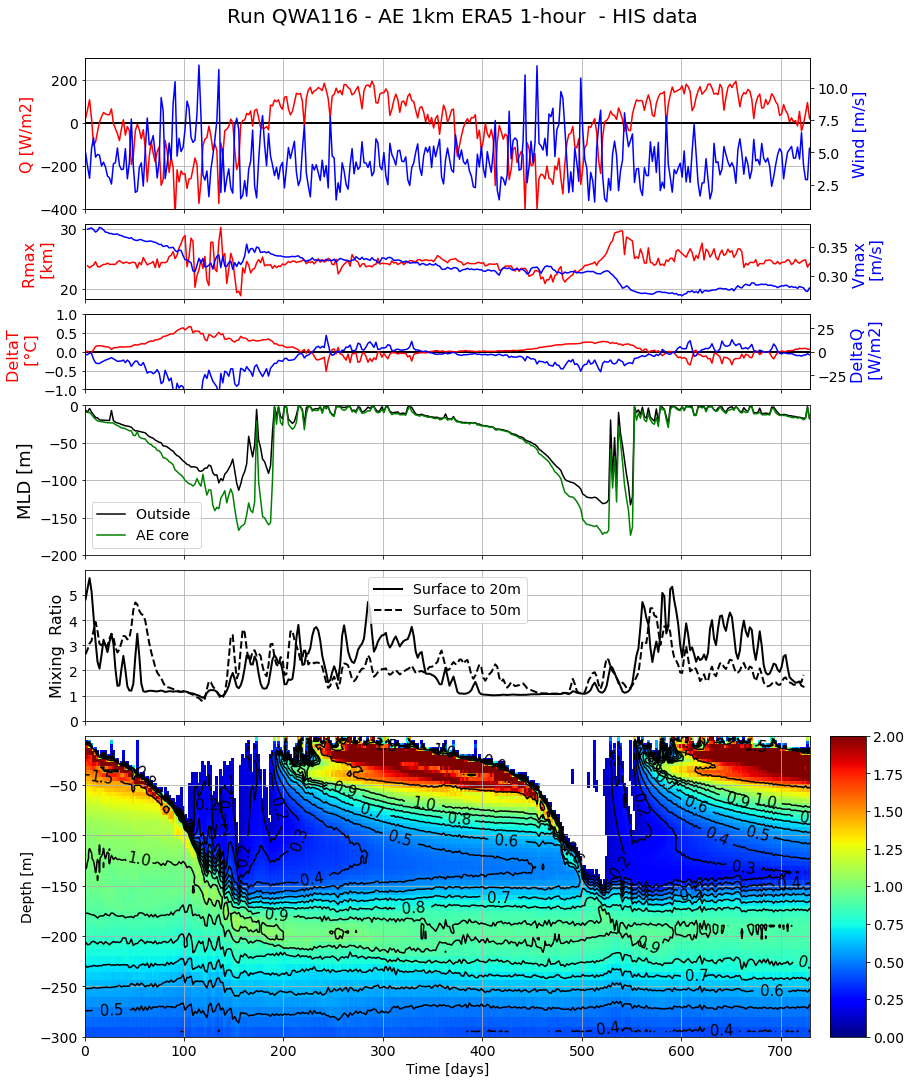

In [79]:
LS=14 ; dTmax=1    ### figure parameter
id20 =np.argmin(np.abs(zvert+20)) ; id50 =np.argmin(np.abs(zvert+50))
Levels=list(np.arange(0.1,1,0.1))+list(np.arange(1,2,0.5))
months=['O','N','D','J','F','M','A','M','J','J','A','S']

plt.figure(0, figsize=(14,18)) ; 
gs = GridSpec(6, 2, width_ratios=[20,1], height_ratios=[2,1,1,2,2,4], wspace=0.05, hspace=0.1)

ax0= plt.subplot(gs[1,0])                                  ###### RMAX
plt.plot(timeeddy,Rmax,'-r')
plt.grid() ; plt.ylabel('Rmax \n [km]', size=16, color='r') ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.xlim([0,2*365])
          
ax1=ax0.twinx(); plt.tick_params(labelbottom=False, labelsize=LS)  ###### VMAX
plt.plot(timeeddy,Vmax,'-b')
plt.ylabel('Vmax \n [m/s]', size=16, color='b')
          
ax2 = plt.subplot(gs[0,0])                            ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.xlim([0,2*365]) ; plt.ylim([-400,300])

ax3=ax2.twinx() ; plt.tick_params(labelsize=LS)     #### Wind  
plt.plot(time, Wspeed,'-b') 
plt.ylabel('Wind [m/s]',size=16, color='b')

ax4 = plt.subplot(gs[2,0])                           ### DeltaSST
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, DeltaT_h,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('DeltaT \n [\N{DEGREE SIGN}C]',size=16,color='r')
plt.yticks(np.arange(-2,3,0.5))
plt.xlim([0,2*365]) ; plt.ylim([-dTmax,dTmax])

ax5=ax4.twinx() ; plt.tick_params(labelsize=LS)    ##### Delta Q
plt.plot(time, Qin-Qmean,'-b') 
plt.ylim([-40,40])
plt.ylabel('DeltaQ \n [W/m2]', size=16, color='b')

plt.subplot(gs[3,0])                                            ### MLD [t]
plt.plot(time, MLDout_h, '-k', label='Outside ')
plt.plot(time, MLDrmax_h, '-g', label='AE core')
plt.xlim([0,2*365]) ; plt.ylim([-200,1]) ; plt.grid()
plt.ylabel('MLD [m]', size=18) ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.legend(fontsize=LS)

plt.subplot(gs[4,0])                                        #### Mixing Ratio
plt.plot(time,nd.gaussian_filter1d(np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1),sigma=1), '-k', lw=2, label='Surface to 20m')
plt.plot(time,nd.gaussian_filter1d(np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1),sigma=1), '--k', lw=2, label='Surface to 50m')
plt.legend(fontsize=LS) ; plt.ylim([0,6]) ; plt.xlim([0,2*365])  ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.yticks(np.arange(0,6))
plt.ylabel('Mixing  Ratio',size=16) ; plt.grid()

plt.subplot(gs[5,0])                                        #### BVF inside
CP1 = plt.pcolor(time, zs, N_eddy_h.T*100,cmap=cm.jet,vmin=0, vmax=2); plt.grid()
CP2 = plt.contour(time, zs, N_eddy_h.T*100,colors=['k'],levels=Levels)
plt.clabel(CP2, fmt='%1.1f',fontsize=15)  ; plt.xlim([0,2*365])
plt.ylabel('Depth [m]',size=LS)  #; plt.legend(['Inside Eddy'], loc=4, fontsize=18)
plt.ylim([-300,-1])  ; plt.tick_params(labelsize=LS) ;  plt.xlabel('Time [days]', size=LS) 
CB=plt.colorbar(CP1,cax=plt.subplot(gs[5,1]))
CB.ax.tick_params(labelsize=LS)

plt.suptitle(str_title+' - HIS data', y=0.92,size=20)


## Thermal feedback 

Text(0.5, 1.02, 'Flux sensibility - Run QWA116 - AE 1km ERA5 1-hour ')

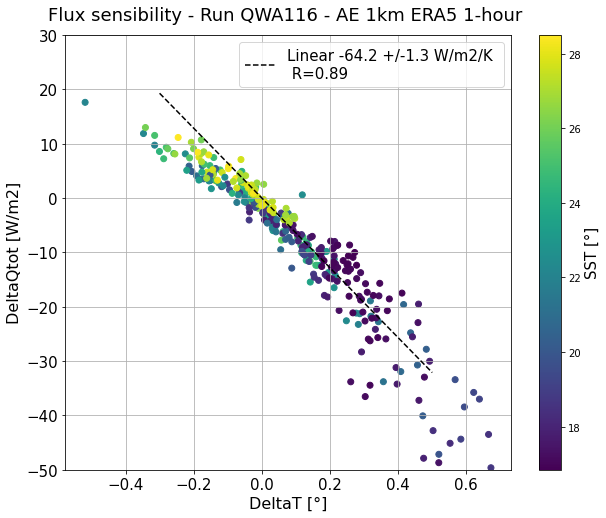

In [82]:
def linear(x,a):
    return a*x
DeltaQ=Qin-Qmean
DeltaT=DeltaT_h[::Nt]  ### Quick fix to have DeltaT at same timesteps than DeltaQ

plt.figure(0, figsize=(10,8))
plt.scatter(DeltaT,DeltaQ, c=SSTout_h[::Nt])  ## at same timesteps than DeltaQ

DeltaQa=DeltaQ[~np.isnan(DeltaQ)] ; DeltaTa=DeltaT[~np.isnan(DeltaQ)]
R=np.cov(DeltaQa,DeltaTa)[0,1]**2/np.std(DeltaQa)**2/np.std(DeltaTa)**2
A0,S=opt.curve_fit(linear,DeltaTa,DeltaQa,[0])
plt.plot(np.arange(-0.3,0.6,0.1),linear(np.arange(-0.3,0.6,0.1),A0),'--k', label='Linear '+'%3.1f'%A0+' +/-'+'%2.1f'%S+' W/m2/K \n R='+'%0.2f'%R)

plt.grid() ; CB = plt.colorbar()
CB.set_label('SST [\N{DEGREE SIGN}]', size=15)
plt.xlabel('DeltaT [\N{DEGREE SIGN}]', size=16)
plt.ylabel('DeltaQtot [W/m2]', size=16)
plt.ylim([-50,30])
plt.tick_params(labelsize=15) ;plt.legend(fontsize=15)
plt.title('Flux sensibility - '+str_title,size=18, y=1.02)

## Save in .npy format

In [83]:
DE={}
DE['timeeddy']=timeeddy   ### 1D vars
DE['Rmax']=Rmax
DE['Vmax']=Vmax
DE['time_a']=time
DE['time_h']=time_h
DE['Qin']=Qin
DE['Qmean']=Qmean
DE['Wspeed']=Wspeed
DE['SSTin_h']=SSTin_h
DE['SSTperif_h']=SSTperif_h
DE['SSTout_h']=SSTout_h
DE['MLDout_h']=MLDout_h
DE['MLDrmax_h']=MLDrmax_h


#DE['WOut_h']=WOut_h  ### 2D var
#DE['WEddy_h']=WEddy_h
DE['TempEddy_h']=TempEddy_h
DE['TempCoreRmin_h']=TempCoreRmin_h
DE['TempOut_h']=TempOut_h
DE['zvert']=zvert
DE['MixEddy_h']=MixEddy_h
DE['MixOut_h']=MixOut_h
DE['z_dzt']=z_dzt
np.save('../Analysis/DictEddy_HIS_'+expname.upper()+'.npy',DE)